In [3]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser
import os

In [4]:
# DATA

# import

station_id=5001
file_path = os.path.join(r'D:\FMF magisterij\Matematika z računalnikom', f'ELES-MAS-{station_id}-2020-2023.csv.gz')
data = pd.read_csv(file_path, compression='gzip')
data = data[data['data_validity'] <= 32]
data.drop('measurement_location_inst_id', axis=1, inplace=True)
data['acquisition_timestamp'] = pd.to_datetime(data['acquisition_timestamp'], utc=True)

# pivoting
new_data = data.pivot_table(index='acquisition_timestamp', columns='parameter_type', values='value').reset_index()
new_data.set_index('acquisition_timestamp', inplace=True)


# ambient rain_intensity
rain_intensity = new_data[['RAIN_INTENSITY']]
print(rain_intensity)

# count the NaN values
nan_count_rain_intensity = rain_intensity['RAIN_INTENSITY'].isna().sum()
print(nan_count_rain_intensity)
# there are no NaN values

# check for missing measurements (skipped times)
complete_range = pd.date_range(start=rain_intensity.index.min(), end=rain_intensity.index.max(), freq='5T')
missing_timestamps = complete_range.difference(rain_intensity.index)
print(len(missing_timestamps))
#print(complete_range)
df_complete_range = pd.DataFrame(index=complete_range)
len(df_complete_range)
# we have 271508 measurements, there are 5112 missing measurment out of 276620 time steps in the whole time range

# fill the missing measurements with the measurment at that time on the previous day (!problem: if the measurment of the previous day at that time is also missing. solution: take the next day)

# merge all the air pressure measurements with all the time steps. missing measurment will be NaN values for now
rain_intensity_incomplete = df_complete_range.merge(rain_intensity, left_index=True, right_index=True, how='left')
# print(rain_intensity_incomplete)
rain_intensity_incomplete.isna().sum() # okay

# missing measurements are filled with the next available measurement
rain_intensity_all = rain_intensity_incomplete.bfill()
print(rain_intensity_all)
rain_intensity_all.isna().sum() # okay

str(rain_intensity_all.index.dtype) # okay

parameter_type             RAIN_INTENSITY
acquisition_timestamp                    
2020-10-13 10:20:00+00:00             0.0
2020-10-13 10:25:00+00:00             0.0
2020-10-13 10:30:00+00:00             0.0
2020-10-13 10:35:00+00:00             0.0
2020-10-13 10:40:00+00:00             0.0
...                                   ...
2023-05-31 21:35:00+00:00             0.0
2023-05-31 21:40:00+00:00             0.0
2023-05-31 21:45:00+00:00             0.0
2023-05-31 21:50:00+00:00             0.0
2023-05-31 21:55:00+00:00             0.0

[271508 rows x 1 columns]
0
5112
                           RAIN_INTENSITY
2020-10-13 10:20:00+00:00             0.0
2020-10-13 10:25:00+00:00             0.0
2020-10-13 10:30:00+00:00             0.0
2020-10-13 10:35:00+00:00             0.0
2020-10-13 10:40:00+00:00             0.0
...                                   ...
2023-05-31 21:35:00+00:00             0.0
2023-05-31 21:40:00+00:00             0.0
2023-05-31 21:45:00+00:00             0.0


'datetime64[ns, UTC]'

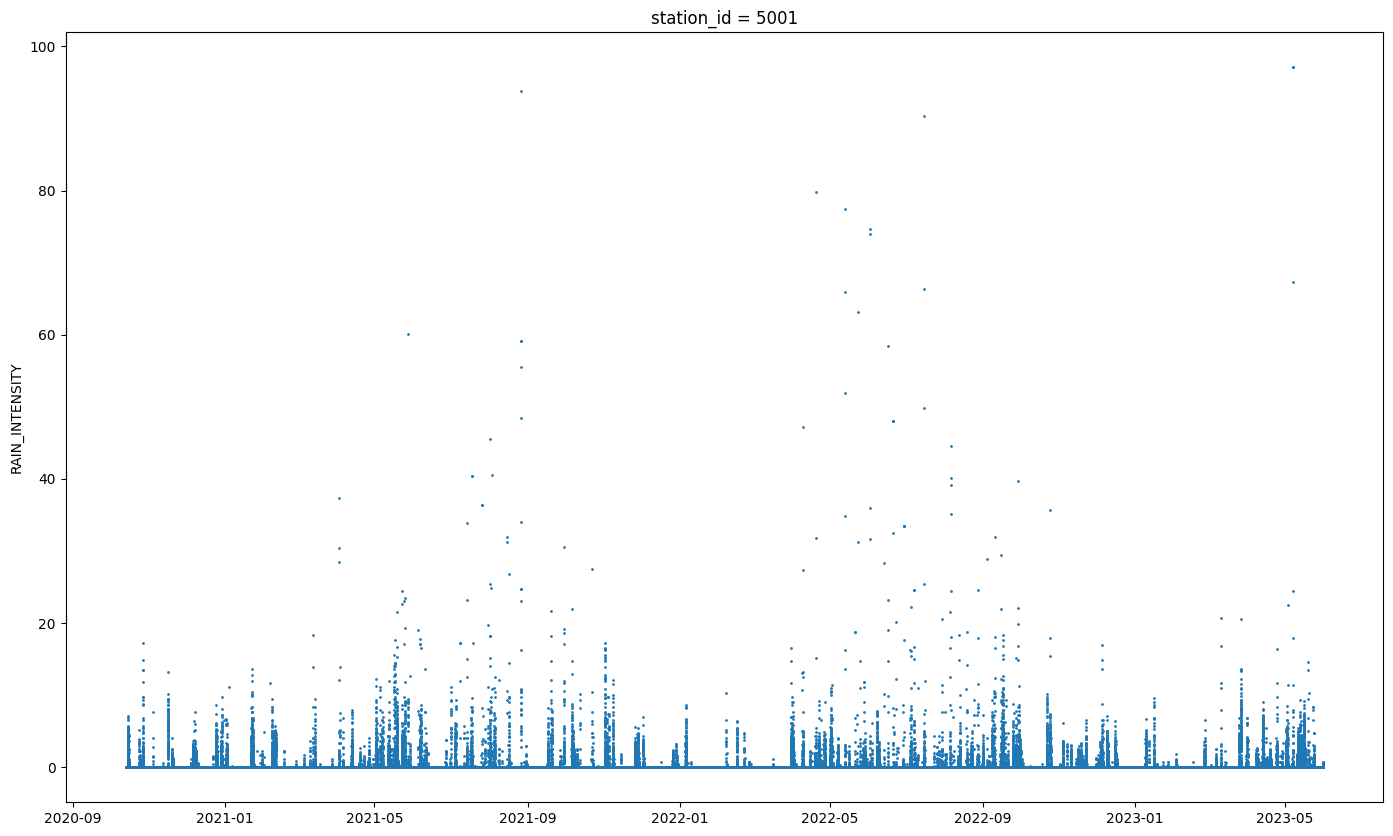

In [5]:
# plot 'RAIN_INTENSITY'
fig, ax = plt.subplots(figsize=(17, 10))
ax.scatter(rain_intensity_all.index, rain_intensity_all['RAIN_INTENSITY'],s=1)
ax.set_ylabel('RAIN_INTENSITY')  
ax.set_title(f'station_id = {station_id}')  
plt.show()

                           RAIN_INTENSITY
2020-10-13 10:00:00+00:00           0.000
2020-10-13 11:00:00+00:00           0.000
2020-10-13 12:00:00+00:00           0.000
2020-10-13 13:00:00+00:00           0.000
2020-10-13 14:00:00+00:00           0.000
...                                   ...
2023-05-31 17:00:00+00:00           0.000
2023-05-31 18:00:00+00:00           0.000
2023-05-31 19:00:00+00:00           0.275
2023-05-31 20:00:00+00:00           0.000
2023-05-31 21:00:00+00:00           0.000

[23052 rows x 1 columns]


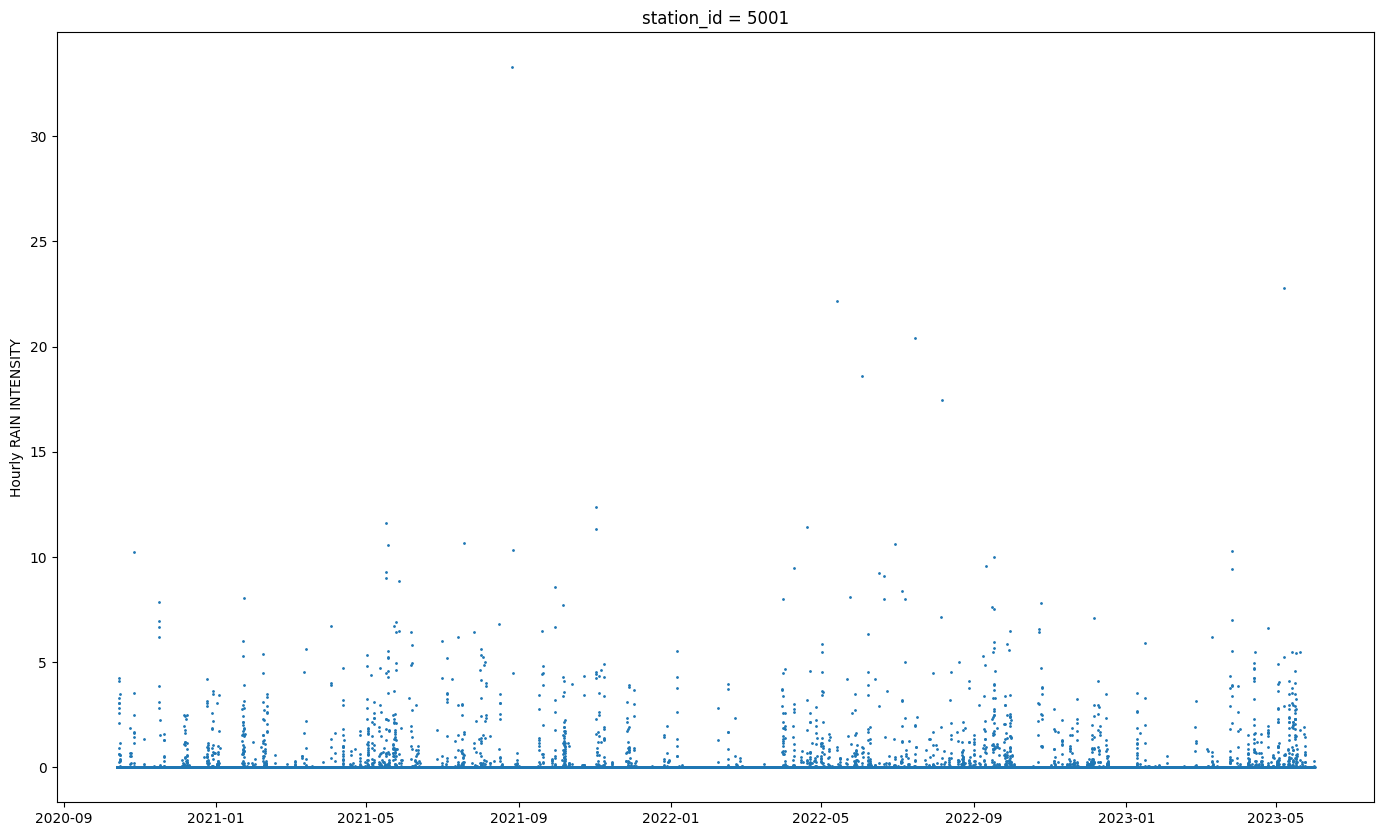

In [6]:
# hourly data
# sum the values for each hour and take the mean

str(rain_intensity_all.index.dtype) # okay
rain_intensity_hourly = rain_intensity_all.resample('H').mean()
print(rain_intensity_hourly)

# plot hourly 'RAIN_INTENSITY'
fig, ax = plt.subplots(figsize=(17, 10))
ax.scatter(rain_intensity_hourly.index, rain_intensity_hourly['RAIN_INTENSITY'],s=1)
ax.set_ylabel('Hourly RAIN INTENSITY')  
ax.set_title(f'station_id = {station_id}')  
plt.show()

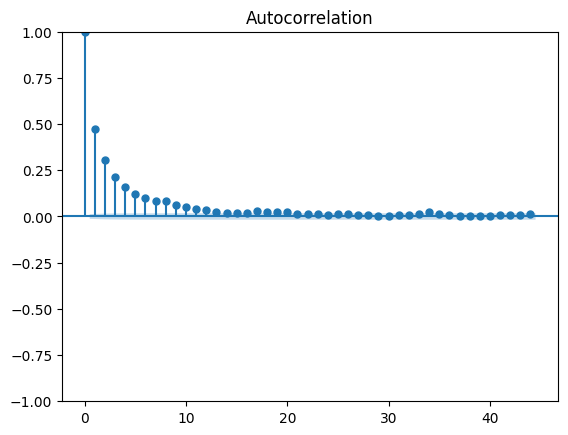

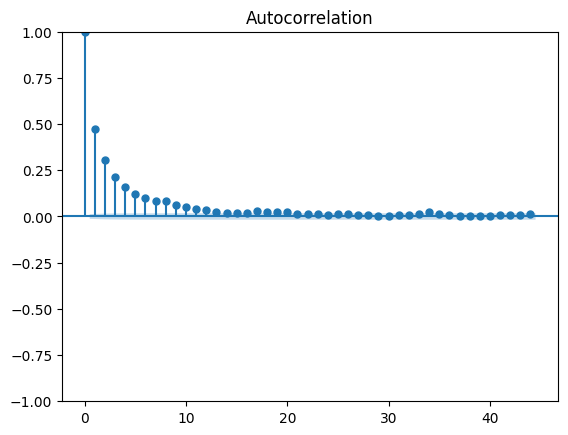

In [7]:
# ARIMA(p, d, q)

# let's look for a suggestion for d by looking at the autocorellation function (ACF) plot

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(rain_intensity_hourly['RAIN_INTENSITY'])

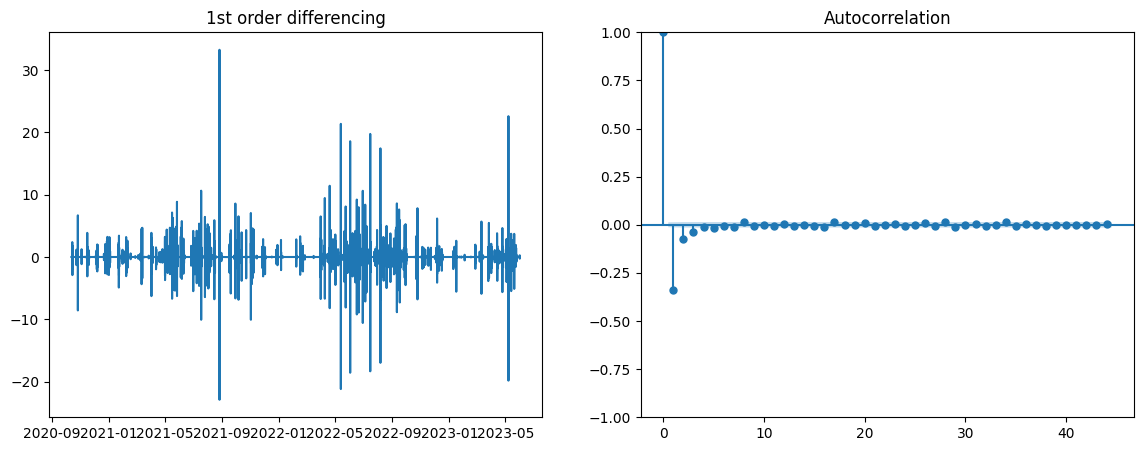

In [8]:
# first differencing and ACF

f = plt.figure(figsize=(14, 5))
ax1 = f.add_subplot(121)
ax1.set_title('1st order differencing')
ax1.plot(rain_intensity_hourly['RAIN_INTENSITY'].diff())

ax2 = f.add_subplot(122)
plot_acf(rain_intensity_hourly['RAIN_INTENSITY'].diff().dropna(), ax=ax2)
plt.show()


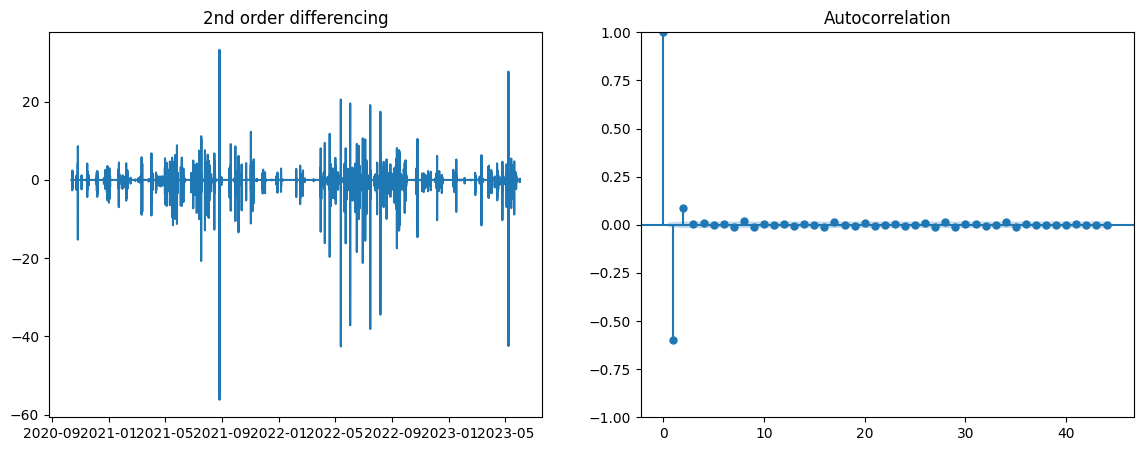

In [9]:
# second differencing and ACF

f = plt.figure(figsize=(14, 5))
ax1 = f.add_subplot(121)
ax1.set_title('2nd order differencing')
ax1.plot(rain_intensity_hourly['RAIN_INTENSITY'].diff().diff())

ax2 = f.add_subplot(122)
plot_acf(rain_intensity_hourly['RAIN_INTENSITY'].diff().diff().dropna(), ax=ax2)
plt.show()

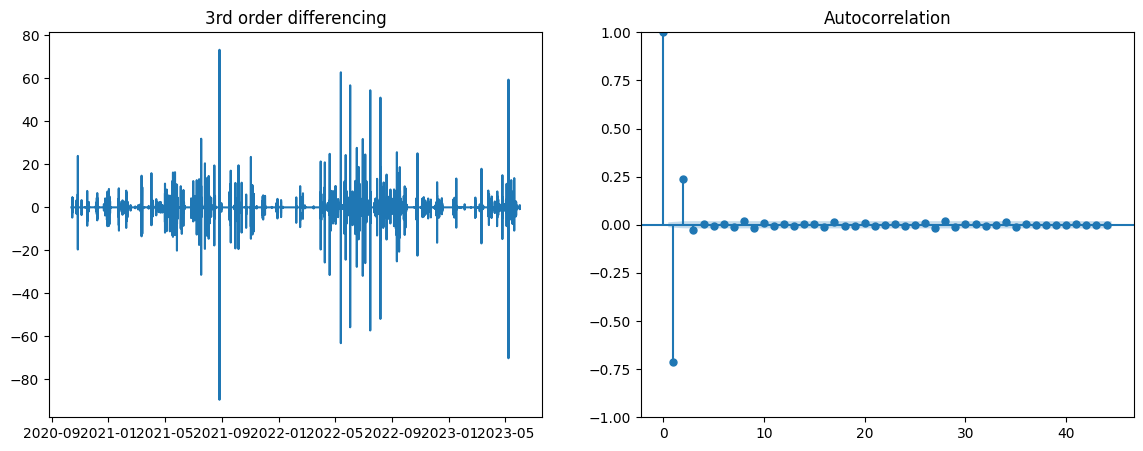

In [10]:
# third differencing and ACF

f = plt.figure(figsize=(14, 5))
ax1 = f.add_subplot(121)
ax1.set_title('3rd order differencing')
ax1.plot(rain_intensity_hourly['RAIN_INTENSITY'].diff().diff().diff())

ax2 = f.add_subplot(122)
plot_acf(rain_intensity_hourly['RAIN_INTENSITY'].diff().diff().diff().dropna(), ax=ax2)
plt.show()

For deciding the appropriate order of differencind, we can to the Augmented Dickey-Fuller test. (more about it for the report is in the air_pressure files). The ADF test aims to reject the null hypothesis that the given time-series data is non-stationary. It calculates the p-value and compares it with a threshold value or significance level of 0.05. If the p-value is less than this level, then the data is stationary; else, the differencing order is incremented by one.

In [11]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(rain_intensity_hourly['RAIN_INTENSITY'].dropna())
print('original data p-value:', result[1])

result = adfuller(rain_intensity_hourly['RAIN_INTENSITY'].diff().dropna())
print('1-diff data p-value:', result[1])

result = adfuller(rain_intensity_hourly['RAIN_INTENSITY'].diff().diff().dropna())
print('2-diff data p-value:', result[1])

result = adfuller(rain_intensity_hourly['RAIN_INTENSITY'].diff().diff().diff().dropna())
print('3-diff data p-value:', result[1])

original data p-value: 0.0
1-diff data p-value: 0.0
2-diff data p-value: 0.0
3-diff data p-value: 0.0


The data is likely stationary.

Now we will look for the best ARIMA(p,d,q) model to fit to the data.

In [11]:
# 1ST WAY OF FINDING THE BEST FIT

# ARIMA for all the hourly ambient rain_intensity data
from pmdarima import auto_arima
stepwise_fit = auto_arima(rain_intensity_hourly, trace=True,
suppress_warnings=True)
# it takes around 10 min

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=44171.481, Time=21.77 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=50352.636, Time=1.44 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=44506.595, Time=0.71 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=46050.356, Time=1.87 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=50912.022, Time=0.70 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=44191.641, Time=5.28 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=44180.462, Time=6.77 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=44178.582, Time=10.67 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=44173.444, Time=22.70 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=44217.501, Time=3.57 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=44179.211, Time=7.29 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=44172.012, Time=13.63 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=44174.573, Time=20.96 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=8.23 sec

Best model:  ARIMA(

                               SARIMAX Results                                
Dep. Variable:         RAIN_INTENSITY   No. Observations:                23052
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -22079.740
Date:                Mon, 20 May 2024   AIC                          44171.481
Time:                        21:17:51   BIC                          44219.754
Sample:                    10-13-2020   HQIC                         44187.166
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1132      0.020      5.552      0.000       0.073       0.153
ar.L1          1.3497      0.048     28.314      0.000       1.256       1.443
ar.L2         -0.4197      0.033    -12.623      0.0

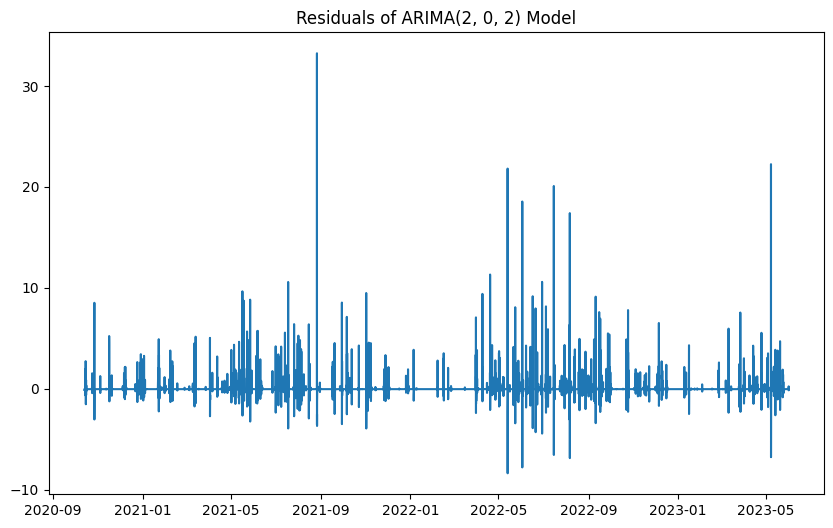

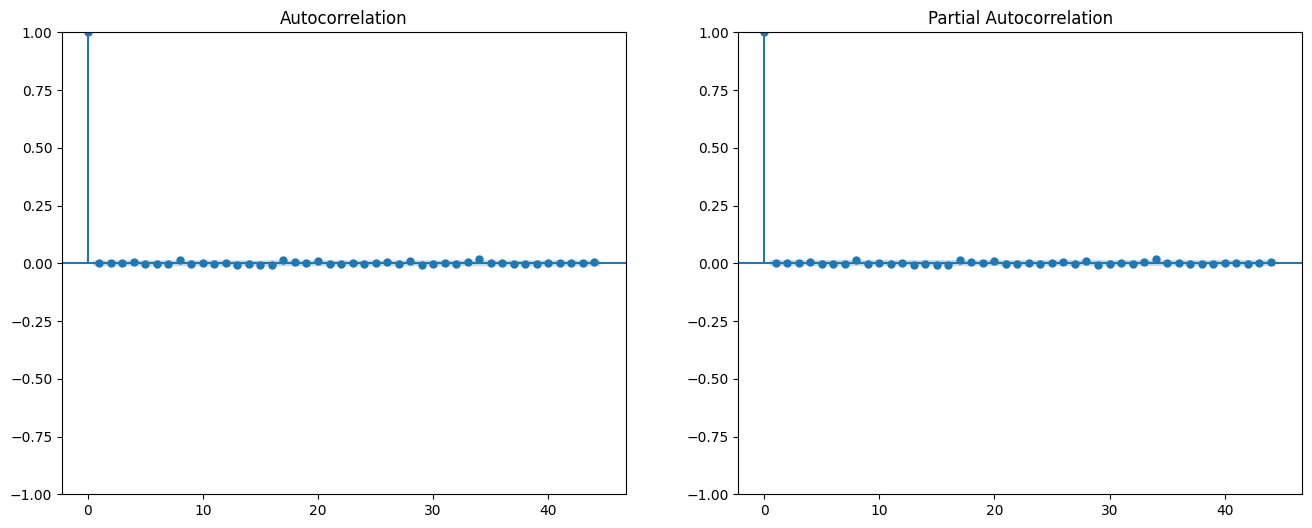

In [12]:
# fit the model 

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# fit the best model
best_model = ARIMA(rain_intensity_hourly, order=(2,0,2))   # change order accordingly
best_fit = best_model.fit()

# summary of the best model
print(best_fit.summary())

# residuals of the best model
residuals_best = best_fit.resid

# plot residuals
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(residuals_best)
plt.title(f'Residuals of ARIMA{2,0,2} Model')
plt.show()

# plot ACF and PACF of the residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(residuals_best, ax=ax[0], alpha=0.05)
plot_pacf(residuals_best, ax=ax[1], alpha=0.05)
plt.show()

        Order           AIC           BIC
38  (2, 0, 2)  44171.480746  44219.753793
55  (3, 0, 1)  44172.011579  44220.284625
39  (2, 0, 3)  44173.439944  44229.758499
73  (4, 0, 1)  44173.550376  44229.868931
57  (3, 0, 3)  44174.546726  44238.910789
Best ARIMA order: (2, 0, 2)
                               SARIMAX Results                                
Dep. Variable:         RAIN_INTENSITY   No. Observations:                23052
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -22079.740
Date:                Mon, 20 May 2024   AIC                          44171.481
Time:                        08:06:15   BIC                          44219.754
Sample:                    10-13-2020   HQIC                         44187.166
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------

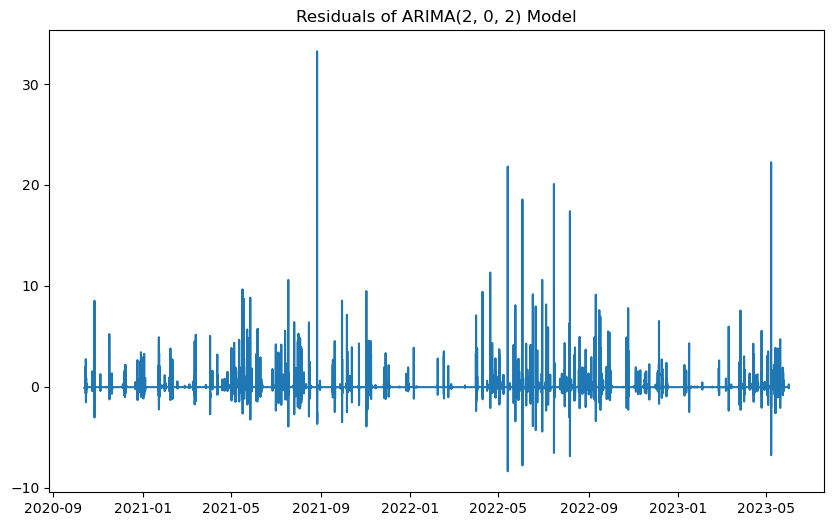

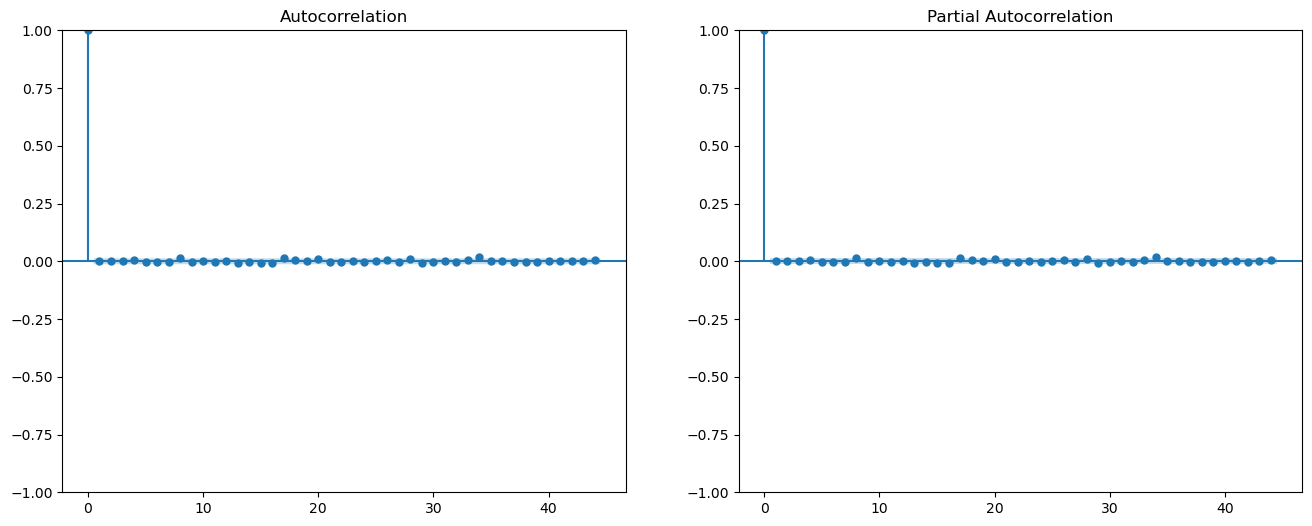

In [14]:
# 2ND WAY OF FINDING THE BEST FIT

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# define the range for p, d, q parameters
p = range(0, 6)
d = range(0, 3)
q = range(0, 6)

# a list to store the results
results = []

# perform grid search
for i in p:
    for j in d:
        for k in q:
            order = (i, j, k)
            try:
                model = ARIMA(rain_intensity_hourly, order=order)
                fit = model.fit()
                aic = fit.aic
                bic = fit.bic
                results.append((order, aic, bic))
            except:
                continue

# convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['Order', 'AIC', 'BIC'])

# sort the results by AIC and BIC
results_df = results_df.sort_values(by='AIC')

# print the top 5 models
print(results_df.head())

# choose the best model based on the lowest AIC
best_order = results_df.iloc[0]['Order']
print(f"Best ARIMA order: {best_order}")

# fit the best model
best_model = ARIMA(rain_intensity_hourly, order=best_order)
best_fit = best_model.fit()

# check the summary of the best model
print(best_fit.summary())

# residuals of the best model
residuals_best = best_fit.resid

# plot residuals
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(residuals_best)
plt.title(f'Residuals of ARIMA{best_order} Model')
plt.show()

# plot ACF and PACF of the residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(residuals_best, ax=ax[0])
plot_pacf(residuals_best, ax=ax[1])
plt.show()

In [14]:
# data for 2020, 2021, 2022
# fit the best model to this data
# 2 best ARIMAs: (2,0,2) and (3,0,1) - first and second way both give (2,0,2), second best from the second way of fitting is (3,0,1)
# forecast the next 24 hours 
# compare forecast from ARIMA and simple model with actual values (maybe 2 simple models)
# plot forecasts, plot errors

rain_intensity_20_21_22 = rain_intensity_hourly.loc[(rain_intensity_hourly.index.year == 2020) | (rain_intensity_hourly.index.year == 2021) | (rain_intensity_hourly.index.year == 2022) , 'RAIN_INTENSITY']
print(rain_intensity_20_21_22)

2020-10-13 10:00:00+00:00    0.0
2020-10-13 11:00:00+00:00    0.0
2020-10-13 12:00:00+00:00    0.0
2020-10-13 13:00:00+00:00    0.0
2020-10-13 14:00:00+00:00    0.0
                            ... 
2022-12-31 19:00:00+00:00    0.0
2022-12-31 20:00:00+00:00    0.0
2022-12-31 21:00:00+00:00    0.0
2022-12-31 22:00:00+00:00    0.0
2022-12-31 23:00:00+00:00    0.0
Freq: H, Name: RAIN_INTENSITY, Length: 19430, dtype: float64


Now we will create two simple models to later compare it with the ARIMA models we fitted to the data.

Simple model: Average of the previous 3 days is the value for the next day.

We fitted ARIMA models to all the hourly data. We will fit the models to the data for just 2020, 2021 and 2022 and then forecast 1 day (24 steps into the 'future', which is the start of the year 2023).

We will then compare the models with the actual data and see which model gives the best forecast. Hopefully it is the ARIMA model.

In [15]:
# 1st simple model
# average of the previous 3 days is the value for the next day

def last_3_days_average(data, forecasted_steps):
    # Forecasts the next values based on the average of the last 3 days at the same time.
    forecast = []

    for step in range(forecasted_steps):

        next_time_step = data.index[-1] + pd.Timedelta(hours=1) # finds out the next time step
        
        last_3_days = [
            next_time_step - pd.Timedelta(days=i) for i in range(1, 4)     # gets the same hour from the last 3 days
        ]
        
        values = [data[data.index == dt].values for dt in last_3_days] # extracts the values at the same hour from the last 3 days
        values = [val[0] if len(val) > 0 else np.nan for val in values]
        
        forecast_value = np.nanmean(values) # mean of the last 3 days
        
        forecast.append(forecast_value)
        
        data = pd.concat([data, pd.Series([forecast_value], index=[next_time_step])]) # adds the forecasted value to the data for the next iteration

    return pd.Series(forecast, index=[data.index[-forecasted_steps + i] for i in range(forecasted_steps)])

last_3_days_average(rain_intensity_20_21_22, 24)

last_3_rain_intensity = last_3_days_average(rain_intensity_20_21_22, 24)

In [16]:
# 2nd simple model
# today's measurement is tomorrow's forecast

def today_is_tomorrow(data, forecasted_steps):

    forecast = []

    for step in range(forecasted_steps):

        next_time_step = data.index[-1] + pd.Timedelta(hours=1)
        
        same_hour_last_day = next_time_step - pd.Timedelta(days=1)
        
        forecast_value = data.loc[same_hour_last_day]
        
        forecast.append(forecast_value)
        
        data = pd.concat([data, pd.Series([forecast_value], index=[next_time_step])])

    return pd.Series(forecast, index=[data.index[-forecasted_steps + i] for i in range(forecasted_steps)])

today_is_tomorrow(rain_intensity_20_21_22, 24)

today_is_tomorrow_rain_intensity = today_is_tomorrow(rain_intensity_20_21_22, 24)

In [17]:
# ARIMA(2,0,2) (1st fit)

# change p,d,q to the best found

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# fit
model_202 = ARIMA(rain_intensity_20_21_22, order=(2,0,2))
fit_202 = model_202.fit()

# summary of the fit
print(fit_202.summary())

# ARIMA forecast for 1 day (24 steps) into the future

forecast_result_202 = fit_202.get_forecast(steps=24)
forecast_values_202 = forecast_result_202.predicted_mean
conf_int_202 = forecast_result_202.conf_int()

print("Forecasted values:", forecast_values_202)
print("95% Confidence intervals of forecasts:", conf_int_202)

                               SARIMAX Results                                
Dep. Variable:         RAIN_INTENSITY   No. Observations:                19430
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -18900.831
Date:                Mon, 20 May 2024   AIC                          37813.663
Time:                        21:37:19   BIC                          37860.910
Sample:                    10-13-2020   HQIC                         37829.142
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1123      0.021      5.255      0.000       0.070       0.154
ar.L1          1.2813      0.048     26.505      0.000       1.187       1.376
ar.L2         -0.3631      0.033    -10.994      0.0

In [18]:
print(forecast_values_202)

2023-01-01 00:00:00+00:00    0.046072
2023-01-01 01:00:00+00:00    0.064993
2023-01-01 02:00:00+00:00    0.075735
2023-01-01 03:00:00+00:00    0.082629
2023-01-01 04:00:00+00:00    0.087562
2023-01-01 05:00:00+00:00    0.091379
2023-01-01 06:00:00+00:00    0.094479
2023-01-01 07:00:00+00:00    0.097065
2023-01-01 08:00:00+00:00    0.099253
2023-01-01 09:00:00+00:00    0.101117
2023-01-01 10:00:00+00:00    0.102711
2023-01-01 11:00:00+00:00    0.104077
2023-01-01 12:00:00+00:00    0.105249
2023-01-01 13:00:00+00:00    0.106253
2023-01-01 14:00:00+00:00    0.107116
2023-01-01 15:00:00+00:00    0.107855
2023-01-01 16:00:00+00:00    0.108490
2023-01-01 17:00:00+00:00    0.109035
2023-01-01 18:00:00+00:00    0.109503
2023-01-01 19:00:00+00:00    0.109904
2023-01-01 20:00:00+00:00    0.110249
2023-01-01 21:00:00+00:00    0.110544
2023-01-01 22:00:00+00:00    0.110798
2023-01-01 23:00:00+00:00    0.111016
Freq: H, Name: predicted_mean, dtype: float64


In [19]:
# ARIMA(3,0,1) (2nd fit)

# change p,d,q to the best found

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# fit
model_301 = ARIMA(rain_intensity_20_21_22, order=(3,0,1))
fit_301 = model_301.fit()

# summary of the fit
print(fit_301.summary())

# ARIMA forecast for 1 day (24 steps) into the future

forecast_result_301 = fit_301.get_forecast(steps=24)
forecast_values_301 = forecast_result_301.predicted_mean
conf_int_301 = forecast_result_301.conf_int()

print("Forecasted values:", forecast_values_301)
print("95% Confidence intervals of forecasts:", conf_int_301)

                               SARIMAX Results                                
Dep. Variable:         RAIN_INTENSITY   No. Observations:                19430
Model:                 ARIMA(3, 0, 1)   Log Likelihood              -18901.134
Date:                Mon, 20 May 2024   AIC                          37814.268
Time:                        21:37:36   BIC                          37861.515
Sample:                    10-13-2020   HQIC                         37829.747
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1123      0.021      5.288      0.000       0.071       0.154
ar.L1          1.1684      0.031     37.623      0.000       1.107       1.229
ar.L2         -0.2484      0.013    -19.710      0.0

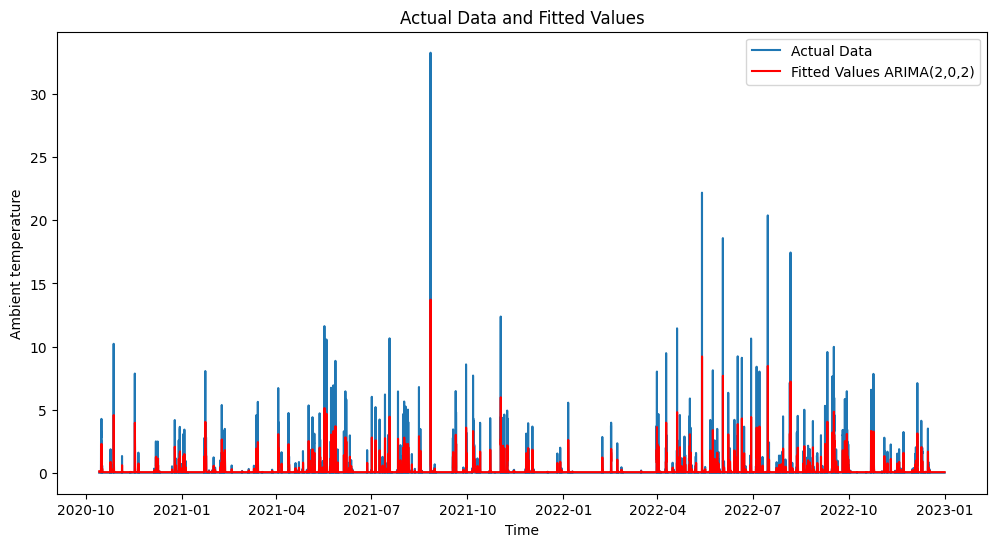

In [20]:
# plot actual data and fitted values - 1ST ARIMA
# change p,d,q to the best found

# fitted values
fitted_values_202 = fit_202.fittedvalues

plt.figure(figsize=(12,6))
plt.plot(rain_intensity_20_21_22.index, rain_intensity_20_21_22, label='Actual Data')
plt.plot(rain_intensity_20_21_22.index, fitted_values_202, color='red', label='Fitted Values ARIMA(2,0,2)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Rain Intensity')
plt.title('Actual Data and Fitted Values')
plt.show()

# this looks too good

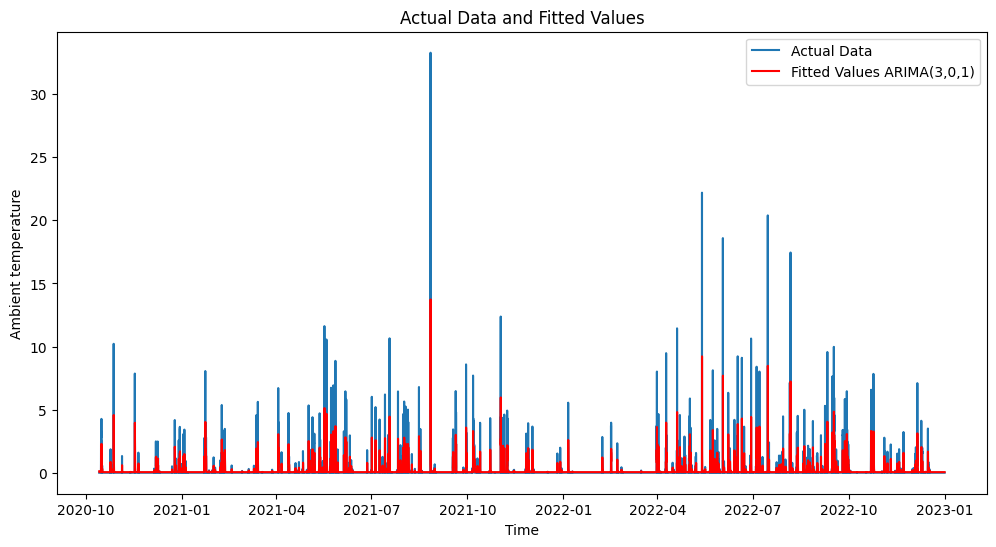

In [21]:
# plot actual data and fitted values - 1ST ARIMA
# change p,d,q to the best found

# fitted values
fitted_values_301 = fit_301.fittedvalues

plt.figure(figsize=(12,6))
plt.plot(rain_intensity_20_21_22.index, rain_intensity_20_21_22, label='Actual Data')
plt.plot(rain_intensity_20_21_22.index, fitted_values_301, color='red', label='Fitted Values ARIMA(3,0,1)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Rain Intensity')
plt.title('Actual Data and Fitted Values')
plt.show()

# this looks too good

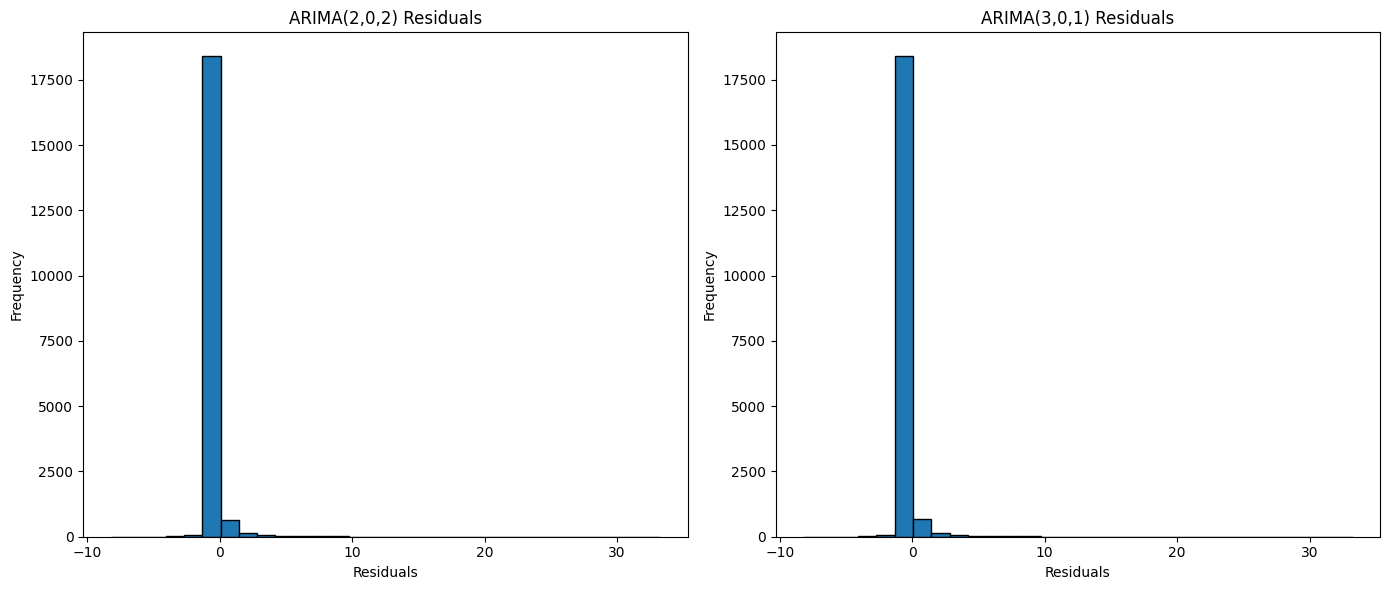

In [22]:
# comparison of the histograms

# residuals
residuals_202 = fit_202.resid
residuals_301 = fit_301.resid

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(residuals_202, bins=30, edgecolor='k')
plt.title('ARIMA(2,0,2) Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(residuals_301, bins=30, edgecolor='k')
plt.title('ARIMA(3,0,1) Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')



plt.tight_layout()
plt.show()


The residuals in a time series model are what is left over after fitting a model. The residuals are equal to the difference between the observations and the corresponding fitted values.

Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will have residuals with the following properties:

1. The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
2. The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.

In [23]:
# statistical test and metricts to determine which model is better

import math 
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro

# mean of the residuals (should be 0)
mean1 = np.mean(residuals_202)
mean2 = np.mean(residuals_301)
#print(mean1, mean2)

# AIC (already done above) - writte about AIC in the report
aic1 = fit_202.aic
aic2 = fit_301.aic
#print(aic1, aic2)
# lower is better
if aic1 < aic2:
    print('ARIMA(2,0,2) is better based on AIC.')
else:
    print('ARIMA(3,0,1) is preferred based on AIC.')

# Ljung-Box test for autocorrelation - see model fit output

# BIC - see model fit output

ARIMA(2,0,2) is better based on AIC.


In [25]:
# actual measurements for 1 day (24 steps) into the future
rain_hourly = rain_intensity_hourly['RAIN_INTENSITY']
actual_values_rain_intensity_23 = rain_hourly['2023'].head(24)
print(actual_values_rain_intensity_23)

2023-01-01 00:00:00+00:00    0.0
2023-01-01 01:00:00+00:00    0.0
2023-01-01 02:00:00+00:00    0.0
2023-01-01 03:00:00+00:00    0.0
2023-01-01 04:00:00+00:00    0.0
2023-01-01 05:00:00+00:00    0.0
2023-01-01 06:00:00+00:00    0.0
2023-01-01 07:00:00+00:00    0.0
2023-01-01 08:00:00+00:00    0.0
2023-01-01 09:00:00+00:00    0.0
2023-01-01 10:00:00+00:00    0.0
2023-01-01 11:00:00+00:00    0.0
2023-01-01 12:00:00+00:00    0.0
2023-01-01 13:00:00+00:00    0.0
2023-01-01 14:00:00+00:00    0.0
2023-01-01 15:00:00+00:00    0.0
2023-01-01 16:00:00+00:00    0.0
2023-01-01 17:00:00+00:00    0.0
2023-01-01 18:00:00+00:00    0.0
2023-01-01 19:00:00+00:00    0.0
2023-01-01 20:00:00+00:00    0.0
2023-01-01 21:00:00+00:00    0.0
2023-01-01 22:00:00+00:00    0.0
2023-01-01 23:00:00+00:00    0.0
Freq: H, Name: RAIN_INTENSITY, dtype: float64


                           Actual  ARIMA(2,0,2)  ARIMA(3,0,1)  \
2023-01-01 00:00:00+00:00     0.0      0.046072      0.046381   
2023-01-01 01:00:00+00:00     0.0      0.064993      0.065450   
2023-01-01 02:00:00+00:00     0.0      0.075735      0.076209   
2023-01-01 03:00:00+00:00     0.0      0.082629      0.083106   
2023-01-01 04:00:00+00:00     0.0      0.087562      0.088105   
2023-01-01 05:00:00+00:00     0.0      0.091379      0.092016   
2023-01-01 06:00:00+00:00     0.0      0.094479      0.095204   
2023-01-01 07:00:00+00:00     0.0      0.097065      0.097857   
2023-01-01 08:00:00+00:00     0.0      0.099253      0.100085   
2023-01-01 09:00:00+00:00     0.0      0.101117      0.101965   
2023-01-01 10:00:00+00:00     0.0      0.102711      0.103554   
2023-01-01 11:00:00+00:00     0.0      0.104077      0.104899   
2023-01-01 12:00:00+00:00     0.0      0.105249      0.106038   
2023-01-01 13:00:00+00:00     0.0      0.106253      0.107002   
2023-01-01 14:00:00+00:00

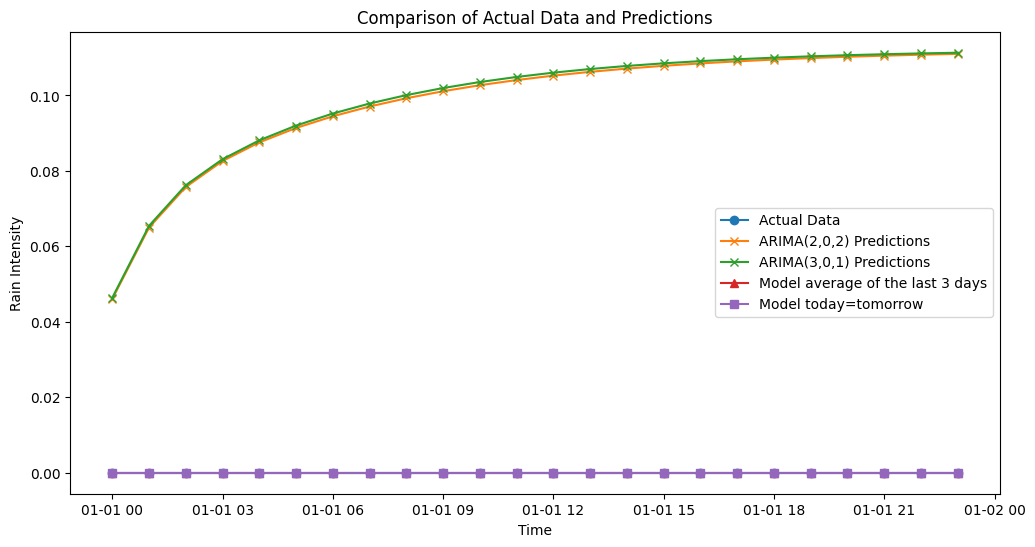

In [26]:
# comparing the models with the actual data
# change p,d,q to the best found

comparison_rain_intensity = pd.DataFrame({
    'Actual': actual_values_rain_intensity_23,
    'ARIMA(2,0,2)': forecast_values_202,
    'ARIMA(3,0,1)': forecast_values_301,
    'Model average of the last 3 days': last_3_rain_intensity,
    'Model today=tomorrow': today_is_tomorrow_rain_intensity
})

print(comparison_rain_intensity)

plt.figure(figsize=(12,6))

plt.plot(comparison_rain_intensity.index, comparison_rain_intensity['Actual'], label='Actual Data', marker='o')
plt.plot(comparison_rain_intensity.index, comparison_rain_intensity['ARIMA(2,0,2)'], label='ARIMA(2,0,2) Predictions', marker='x')
plt.plot(comparison_rain_intensity.index, comparison_rain_intensity['ARIMA(3,0,1)'], label='ARIMA(3,0,1) Predictions', marker='x')
plt.plot(comparison_rain_intensity.index, comparison_rain_intensity['Model average of the last 3 days'], label='Model average of the last 3 days', marker='^')
plt.plot(comparison_rain_intensity.index, comparison_rain_intensity['Model today=tomorrow'], label='Model today=tomorrow', marker='s')

plt.xlabel('Time')
plt.ylabel('Rain Intensity')
plt.title('Comparison of Actual Data and Predictions')
plt.legend()
plt.show()

# try another day? everything is 0 exept ARIMA because there was no rain in the last 3 days and on the predicted day